<a href="https://colab.research.google.com/github/MoisesGuerreroUdeA/Seminario-Analitica-CDatos/blob/dataset-castile-leon/jupyter/ME04/ME04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diseño de una solución para la predicción de radiación solar en diferentes escalas temporales para la región de la Comunidad de Castilla y León, España, para la gestión de proyectos de generación fotovoltaica.

## Seminario de Analítica y Ciencia de Datos

Moisés Alfonso Guerrero Jiménez, Andrés Castaño Licona

### Descripción Datos

Los datos usados hacen parte de un repositorio abierto con licencia *Creative Commons Attribution*, que contiene mediciones de radiación horizontal global solar (GHI), recopiladas durante un periodo de 18 años, desde el 1 de enero de 2002 hasta el 31 de diciembre de 2019, con una granularidad de 30 minutos, que fueron medidos en 37 estaciones ubicadas en la región española de Castilla y León.

El conjunto de datos no solo cuenta con datos crudos, sino también con datos refinados y etiquetados por estaciones de medición, contando además con variables meteorológicas y geográficas que complementan el valor de los datos de irradiación.

Los datos fueron publicados por integrantes del Departamento de Ingeniería Topográfica y Cartográfica de la Escuela Técnica Superior de Ingenieros en Topografía, Geodesia y Cartografía, Universidad Politécnica de Madrid, y se encuentran disponibles para su uso con fines de investigación en un repositorio público con nombre “CyL_GHI” disponible en el sitio web Zenodo (https://zenodo.org/records/7404167), y además cuentan con una documentación detallada con nombre *“CyL-GHI: Global Horizontal Irradiance Dataset Containing 18 Years of Refined Data at 30-Min Granularity from 37 Stations Located in Castile and León (Spain)”*, que describe de manera precisa mucho del preprocesamiento, estandarización y limpieza realizado por los autores, así como muchas de las características del dataset.

La lectura de los datos requiere de un paso inicial de descarga del repositorio de Zenodo, para lo cual se hace uso del comando `wget` de linux, que nos permite realizar la descarga directamente al directorio de ejecución en Colab.

In [1]:
# Descarga de datos crudos para ser procesados y analizados
! wget https://zenodo.org/records/7404167/files/CyL_raw.zip

# Descarga de los datos geográficos
! wget https://zenodo.org/records/7404167/files/CyL_geo.csv

--2023-11-19 21:14:58--  https://zenodo.org/records/7404167/files/CyL_raw.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232640787 (222M) [application/octet-stream]
Saving to: ‘CyL_raw.zip’

CyL_raw.zip         100%[===================>] 221.86M  30.3MB/s    in 8.2s    

2023-11-19 21:15:07 (27.0 MB/s) - ‘CyL_raw.zip’ saved [232640787/232640787]

--2023-11-19 21:15:07--  https://zenodo.org/records/7404167/files/CyL_geo.csv
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2429 (2.4K) [text/plain]
Saving to: ‘CyL_geo.csv’

CyL_geo.csv         100%[===================>]   2.37K  --.-KB/s    in 0s      

2023-11-19 21:15:08 (953 MB/s) - ‘CyL_geo.csv’ sav

In [2]:
# Se descomprime el archivo CyL_raw.zip en un directorio con nombre CyL_raw
! unzip -q CyL_raw.zip -d CyL_raw/

In [3]:
# Listamos el contenido del directorio con los archivos descomprimidos
! ls -l CyL_raw/

total 504
drwxr-xr-x 2 root root 28672 Mar 18  2022 2002
drwxr-xr-x 2 root root 28672 Mar 18  2022 2003
drwxr-xr-x 2 root root 28672 Mar 18  2022 2004
drwxr-xr-x 2 root root 28672 Mar 18  2022 2005
drwxr-xr-x 2 root root 28672 Mar 18  2022 2006
drwxr-xr-x 2 root root 24576 Mar 18  2022 2007
drwxr-xr-x 2 root root 28672 Mar 18  2022 2008
drwxr-xr-x 2 root root 24576 Mar 18  2022 2009
drwxr-xr-x 2 root root 28672 Mar 18  2022 2010
drwxr-xr-x 2 root root 28672 Mar 18  2022 2011
drwxr-xr-x 2 root root 28672 Mar 18  2022 2012
drwxr-xr-x 2 root root 28672 Mar 18  2022 2013
drwxr-xr-x 2 root root 28672 Mar 18  2022 2014
drwxr-xr-x 2 root root 28672 Mar 18  2022 2015
drwxr-xr-x 2 root root 28672 Mar 18  2022 2016
drwxr-xr-x 2 root root 28672 Mar 18  2022 2017
drwxr-xr-x 2 root root 32768 Mar 18  2022 2018
drwxr-xr-x 2 root root 32768 Mar 18  2022 2019


Tal como se observa, los datos crudos se encuentran almacenados en subcarpetas referentes a cada año de mediciones realizadas entre el 2002 y el 2019.

Una revisión manual desde la interfaz de Colab permite observar que cada subcarpeta cuenta con archivos en formato *zip* que contienen archivos en formato *csv* con las mediciones realizadas a lo largo de un día.

Los archivos comprimidos por día, son facilmente identificables por medio de un prefijo que indica la fecha en la cual se realizaron las mediciones de acuerdo al patrón `YYYYMMDD_RedClimaITACYL_Horario.zip`, donde `YYYYMMDD` corresponde al día de mediciones para el año de cada subcarpeta.

In [4]:
# Importamos librerías que serán usadas en todo el proceso
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

### Extracción, transformación y carga de datos

Dado que se requiere visualizar y entender la forma en la cual se encuentran distribuidas las distintas variables medidas en el conjunto de datos, es necesario realizar un proceso de extracción, transformación y carga de la información relevante para el proceso en cuestión, para lo cual se realiza primero una descompresión dinámica de cada uno de los archivos *csv* almacenados por cada *zip* en los subdirectorios antes mencionados

In [ ]:
# Creamos un listado de los años en los cuales se tienen mediciones
# En este caso solo se trabajará con una muestra de los 3 primeros años
# years = range(2002, 2020, 1) # 2002 - 2019
years = range(2002, 2005, 1) # 2002 - 2004

# Creamos un directorio temporal donde se almacenarán los datos csv extraídos de cada subdirectorio
os.makedirs("temp_CyL", exist_ok=True)

# Para cada año se listan todos los archivos zip y se ejecuta un comando que los extrae en un subdirectorio en temp_CyL
for year in years:
    print(f"Listando archivos para el año {year}...")
    # Usamos la librería os para listar los archivos en el directorio CyL_raw/
    files_list = os.listdir(f"CyL_raw/{year}/")
    # Para cada archivo incluido en el listado ejecutamos un comando de descompresión por medio de os
    for file in files_list:
        os.popen(f"unzip -q CyL_raw/{year}/{file} -d temp_CyL/{year}/")

In [6]:
# Luego de la ejecución listamos uno de los directorios para verificar los archivos extraídos
print(os.listdir(f"temp_CyL/2002"))

['20020711_RedClimaITACYL_Horario.csv', '20020830_RedClimaITACYL_Horario.csv', '20020901_RedClimaITACYL_Horario.csv', '20020524_RedClimaITACYL_Horario.csv', '20020806_RedClimaITACYL_Horario.csv', '20020120_RedClimaITACYL_Horario.csv', '20020115_RedClimaITACYL_Horario.csv', '20020629_RedClimaITACYL_Horario.csv', '20021112_RedClimaITACYL_Horario.csv', '20020804_RedClimaITACYL_Horario.csv', '20020906_RedClimaITACYL_Horario.csv', '20020510_RedClimaITACYL_Horario.csv', '20020427_RedClimaITACYL_Horario.csv', '20021229_RedClimaITACYL_Horario.csv', '20020209_RedClimaITACYL_Horario.csv', '20020317_RedClimaITACYL_Horario.csv', '20021027_RedClimaITACYL_Horario.csv', '20020813_RedClimaITACYL_Horario.csv', '20020918_RedClimaITACYL_Horario.csv', '20021006_RedClimaITACYL_Horario.csv', '20020203_RedClimaITACYL_Horario.csv', '20020705_RedClimaITACYL_Horario.csv', '20020617_RedClimaITACYL_Horario.csv', '20020925_RedClimaITACYL_Horario.csv', '20020215_RedClimaITACYL_Horario.csv', '20021125_RedClimaITACYL

De acuerdo a la documentación del dataset, las mediciones fueron realizadas en un total de 37 estaciones meteorológicas, por lo cual es necesario realiza la extracción de los datos por cada estación meteorológica en cada día.

In [7]:
# Primero se obtiene la tabla que relaciona las 37 estaciones meteorológicas con dataframe de pandas
df_geo = pd.read_csv("CyL_geo.csv", header = 0, sep = ',', index_col=0)
df_geo.head()

,station_code,name,latitude,longitude,height
0,AV01,Nava de Arévalo,40.968828,-4.767943,921
1,BU02,Valle de Valdelucio,42.746260,-4.132867,976
2,BU03,Lerma,42.039658,-3.768196,840
3,BU04,Tardajos,42.346138,-3.802584,822
4,BU05,Vadocondes,41.637103,-3.576803,811


In [8]:
df_geo.dtypes

station_code     object
name             object
latitude        float64
longitude       float64
height            int64
dtype: object

Este dataframe cuenta con 5 columnas asociadas con un código único, nombre, latitud, longitud y altitud de cada estación meteorológica en la región de Castilla y León.

In [9]:
# Realizamos una previsualización de los datos almacenados en 1 de los csv de mediciones
! head temp_CyL/2002/20020101_RedClimaITACYL_Horario.csv -n 6

C�digo;Ubicaci�n;Fecha (AAAA-MM-DD);Hora (HHMM);Precipitaci�n (mm);Temperatura (�C);Humedad relativa (%);Radiaci�n (W/m2);Vel. viento (m/s);Dir. viento (�)
AV01;Nava de Ar�valo;2002-01-01;0030;0.00;8.67;81.80;0.00;2.27;142.80
AV01;Nava de Ar�valo;2002-01-01;0100;0.00;8.54;82.60;0.00;2.37;148.00
AV01;Nava de Ar�valo;2002-01-01;0130;0.00;8.60;82.90;0.00;2.29;153.20
AV01;Nava de Ar�valo;2002-01-01;0200;0.00;8.49;83.40;0.00;1.51;156.70
AV01;Nava de Ar�valo;2002-01-01;0230;0.00;7.91;85.10;0.00;1.15;157.40


Tal como se observa, los datos crudos cuentan con un encabezado con 10 columnas separadas por punto y coma (;), correspondientes a:

* **Código:** Código único de la estación en la cual se realizaron las mediciones.
* **Ubicación:** Indica el nombre de la estación de medición de acuerdo a su ubicación.
* **Fecha (AAAA-MM-DD):** Hace referencia a la fecha en la cual se realizaron las mediciones (UTC).
* **Hora (HHMM):** Indica la hora en la cual se realizó la medición para la fecha correspondiente (UTC).
* **Precipitación (mm):** Precipitaciones medidas en milímetros en la ubicación de la estación de medición.
* **Temperatura (°C):** Temperatura en grados celsius medida en la ubicación de la estación meteorológica.
* **Humedad relativa (%):** Indica el porcentaje de humedad medido.
* **Radiación (W/m2):** Medición de la radiación solar global horizontal (GHI).
* **Vel. viento (m/s):** Velocidad del viento medida en $m/s$.
* **Dir. viento (°):** Dirección del viento en grados.

Sin embargo, se observan caracteres especiales que sugieren que el archivo debe ser leído con una codificación diferente a `UTF-8`. De acuerdo a la documentación disponible en https://docs.python.org/3/library/codecs.html#standard-encodings, hacemos uso de una codificación `latin-1`, lo que permite visualizar correctamente los datos al ser leídos.

Tal como se observa a continuación al intentar leer el archivo con la codificación por defecto no es posible leer el archivo.

In [10]:
try:
    # Ejemplo de archivo leído con utf-8
    df_ex_encoding = pd.read_csv("temp_CyL/2002/20020101_RedClimaITACYL_Horario.csv", header=0, sep=';', encoding='utf-8')
except Exception as e:
    print(f"No fue posible leer el archivo con la codificación 'utf-8' debido a: \n{e}")
    print("Leyendo archivo con codificación 'latin-1'...")
    df_ex_encoding = pd.read_csv("temp_CyL/2002/20020101_RedClimaITACYL_Horario.csv", header=0, sep=';', encoding='latin-1')

df_ex_encoding.head(5)

No fue posible leer el archivo con la codificación 'utf-8' debido a: 
'utf-8' codec can't decode byte 0xf3 in position 1: invalid continuation byte
Leyendo archivo con codificación 'latin-1'...


,Código,Ubicación,Fecha (AAAA-MM-DD),Hora (HHMM),Precipitación (mm),Temperatura (ºC),Humedad relativa (%),Radiación (W/m2),Vel. viento (m/s),Dir. viento (º)
0,AV01,Nava de Arévalo,2002-01-01,30,0.0,8.67,81.8,0.0,2.27,142.8
1,AV01,Nava de Arévalo,2002-01-01,100,0.0,8.54,82.6,0.0,2.37,148.0
2,AV01,Nava de Arévalo,2002-01-01,130,0.0,8.60,82.9,0.0,2.29,153.2
3,AV01,Nava de Arévalo,2002-01-01,200,0.0,8.49,83.4,0.0,1.51,156.7
4,AV01,Nava de Arévalo,2002-01-01,230,0.0,7.91,85.1,0.0,1.15,157.4


In [11]:
# Construimos una función que nos permita hacer el preprocesamiento de cada dataframe para ser unificados
def preprocesamientoDatos(path):
    """
    Realiza la lectura y el preprocesamiento de los datos para ser estandarizados
    """
    # Se realiza la lectura con una codificación "latin-1" para lectura de los caracteres especiales
    df = pd.read_csv(path, header=0, sep=';', encoding='latin-1')

    # Actualización de los nombres de las columnas
    df.rename(columns={
        "Código": "station_code",
        "Ubicación": "station_name",
        "Fecha (AAAA-MM-DD)": "date",
        "Hora (HHMM)": "time",
        "Precipitación (mm)": "precipitation",
        "Temperatura (ºC)": "air_temp",
        "Humedad relativa (%)": "humidity",
        "Radiación (W/m2)": "GHI",
        "Vel. viento (m/s)": "wind_sp",
        "Dir. viento (º)": "wind_dir"
    }, inplace=True)

    # Dado que pandas autimáticamente interpreta los tipos de dato se realizan transformaciones a los mismos
    # Llenamos los 4 caracteres de la hora
    df['time']  = df.time.astype(str).str.zfill(4)

    # Creamos una marca de tiempo a partir de los datos de fecha y hora
    df['timestamp'] = df['date'] + ' ' + df['time']
    # Modificamos aquellos cuya hora se encuentra a las 24:00 que corresponde a 00:00 del día siguiente
    df['timestamp'] = df['timestamp']\
        .apply(lambda x: x if x[-4:] != '2400' else datetime.strftime(datetime.strptime(x[:10], '%Y-%m-%d') + timedelta(1), '%Y-%m-%d') + ' 0000')
    # Convertimos los datos a datetime64
    df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H%M')
    # Borramos las columnas date y time
    df.drop(columns=['date', 'time'])
    return df

In [ ]:
# Para cada archivo por cada subcarpeta, realizamos la unificación temporal de los datos a un único DataFrame

df_general = pd.DataFrame() # Dataframe vacío
for year in years:
    print(f"Cargando archivos para el año {year}...")
    # Usamos la librería os para listar los archivos en el directorio temp_CyL/
    files_list = os.listdir(f"temp_CyL/{year}/")
    # Para cada archivo incluido en el listado realizamos una lectura y preprocesamiento
    for file in files_list:
        df_temp = preprocesamientoDatos(f"temp_CyL/{year}/{file}")
        df_general = pd.concat([df_general, df_temp])

# Verificamos el df_general creado
print(f"Dimensiones del dataframe general creado: {df_general.shape}")

Posterior a la unificación de los datos, el objetivo es generar archivos individuales por estación meteorológica, esto se realiza de manera automática por medio de una función que a partir del dataframe general, construye archivos temporales en formato *csv* por cada una de las estaciones meteorológicas, tomando como referencia el listado de estaciones relacionadas en el dataframe de posicionamiento geográfico `df_geo`. Estos datos son posteriormente almacenados en un directorio con nombre `temp_CyL_stations/` donde se tendrán ordenados y podrán ser consultados de manera dinámica para la construcción del dataset final.

In [13]:
# Para cada estación meteorológica se realiza el filtrado del dataframe general
station_codes = df_geo['station_code'].tolist()

# Creamos un listado con el orden de las columnas de salida
output_columns_order = [
    "timestamp", # Marca de tiempo (UTC)
    "GHI", # (W/m2)
    "air_temp", # (°C)
    "humidity", # (%)
    "precipitation", # (mm)
    "wind_sp", # (m/s)
    "wind_dir" # (°)
]

# Creamos el directorio temporal
os.makedirs("temp_CyL_stations", exist_ok=True)

# Para cada estación se guarda el csv ordenado
for station in station_codes:
    print(f"Extrayendo y guardando datos de estación {station}...")
    df_general[df_general.station_code == station]\
      .sort_values(by = 'timestamp')[output_columns_order]\
      .to_csv(f"temp_CyL_stations/{station}.csv", header=True, index=False, sep=',')

Extrayendo y guardando datos de estación AV01...
Extrayendo y guardando datos de estación BU02...
Extrayendo y guardando datos de estación BU03...
Extrayendo y guardando datos de estación BU04...
Extrayendo y guardando datos de estación BU05...
Extrayendo y guardando datos de estación LE01...
Extrayendo y guardando datos de estación LE02...
Extrayendo y guardando datos de estación LE03...
Extrayendo y guardando datos de estación LE04...
Extrayendo y guardando datos de estación LE05...
Extrayendo y guardando datos de estación LE06...
Extrayendo y guardando datos de estación LE07...
Extrayendo y guardando datos de estación LE08...
Extrayendo y guardando datos de estación LE09...
Extrayendo y guardando datos de estación P01...
Extrayendo y guardando datos de estación P02...
Extrayendo y guardando datos de estación P03...
Extrayendo y guardando datos de estación P04...
Extrayendo y guardando datos de estación P06...
Extrayendo y guardando datos de estación P07...
Extrayendo y guardando dat

### Obtención de radiación solar incidente teórica

Con el objetivo de complementar el conjunto de datos, se busca mediante el desarrollo de una función obtener la radiación solar incidente teórica para una latitud y longitud específicas.

De acuerdo a lo comentado en ["Cálculo de la radiación solar extraterrestre en función de la latitud y la declinación solar"](https://m.riunet.upv.es/bitstream/handle/10251/68296/Bautista%20-%20C%C3%A1lculo%20de%20la%20radiaci%C3%B3n%20solar%20extraterrestre%20en%20funci%C3%B3n%20de%20la%20latitud%20y%20la%20declinaci%C3%B3n....pdf?sequence=1&isAllowed=y) es posible obtener dicho valor mediante ecuaciones que describen la radiación solar teórica extraterreste.

Por medio del dataframe de datos geográficos `df_geo`, podemos hacer uso de las latitudes y longitudes específicas de cada estación de medición y de esta manera complementar los datos para cada estación meteorológica.

In [14]:
def radiacion_solar_S0(dia_anho):
    """
    Obtiene el valor del parámetro solar S0 o densidad de flujo de la radiación
    que se recibe sobre una superficie perpendicular a los rayos solares para
    un día del año de 1 a 365.
    """
    dia_ref = 81  # 22 de marzo
    if dia_anho < 81:
        D = 365 - dia_ref + dia_anho
    else:
        D = dia_anho - dia_ref
    constante_solar = 1367.
    distancia_media_sol = 149597870000.  # metros

    d = (1.496 * 10 ** 11) * (1 - 0.017 * math.sin(math.radians(0.9856 * D)))
    return constante_solar * ((distancia_media_sol / d) ** 2)

def declinacion_solar(dia_anho):
    """
    Obtiene la posición relativa del sol respecto a la superficie de la tierra
    en un día específico del año de 1 a 365.
    """
    return 23.5 * math.cos(math.radians((360 * (dia_anho - 172) / 365.)))

def hora_solar(dia_anho, hora, longitud, longitud_del_huso, adelanto_hora_verano=0):
    """
    Realiza una corrección astronómica de la hora del día convencional
    transformandola en la hora solar.
    """
    M = dia_anho * 2. * math.pi / 365.24
    EoT = 229.19 * (-0.0334 * math.sin(math.radians(M)) + 0.04184 * math.sin(math.radians(2 * M + 3.5884)))
    return 15 * (hora - adelanto_hora_verano - 12) + (longitud - longitud_del_huso) + EoT / 4.0

def radiacion_solar_teorica(dia, hora, latitud, longitud, longitud_huso_horario, hora_verano=0):
    """
    Obtiene la radiación solar teórica para un punto de la tierra, teniendo en
    cuenta la ubicación geográfica, la declinación, el parámetro solar S0 y la
    hora solar.
    """
    S0 = radiacion_solar_S0(dia)
    inc = declinacion_solar(dia)
    w = hora_solar(dia, hora, longitud, longitud_huso_horario, hora_verano)
    S = S0 * math.sin(math.radians(90 - latitud + inc)) * math.cos(math.radians(w))
    return S if S>=0 else 0

El siguiente ejemplo toma los datos de la estación de medición en Nava de Arévalo (AV01) y a partir de la latitud y longitud, así como la longitud del uso horario, permite obtener valores de GHI teórico.

In [15]:
longitud_huso = 0 # Longitud del huso horario en españa

# A partir de las funciones, adicionamos una columna de radiación teórica
df_test = pd.read_csv("temp_CyL_stations/AV01.csv", sep = ',')
df_test['timestamp'] = pd.to_datetime(df_test.timestamp, format = '%Y-%m-%d %H:%M:%S')

In [16]:
latitude = df_geo[df_geo.station_code == 'AV01']['latitude'].iloc[0]
longitude = df_geo[df_geo.station_code == 'AV01']['longitude'].iloc[0]

df_test['theoretical_radiation'] = df_test.apply(lambda row : radiacion_solar_teorica(row['timestamp'].dayofyear,
                     row["timestamp"].hour + row["timestamp"].minute/60., latitude, longitude, longitud_huso), axis = 1)

df_test

,timestamp,GHI,air_temp,humidity,precipitation,wind_sp,wind_dir,theoretical_radiation
0,2002-01-01 00:30:00,0.0,8.67,81.8,0.0,2.27,142.8,0.0
1,2002-01-01 01:00:00,0.0,8.54,82.6,0.0,2.37,148.0,0.0
2,2002-01-01 01:30:00,0.0,8.60,82.9,0.0,2.29,153.2,0.0
3,2002-01-01 02:00:00,0.0,8.49,83.4,0.0,1.51,156.7,0.0
4,2002-01-01 02:30:00,0.0,7.91,85.1,0.0,1.15,157.4,0.0
...,...,...,...,...,...,...,...,...
52598,2004-12-31 22:00:00,0.0,4.92,93.5,0.0,1.23,96.0,0.0
52599,2004-12-31 22:30:00,0.0,4.97,94.1,0.0,1.17,111.5,0.0
52600,2004-12-31 23:00:00,0.0,5.08,93.2,0.0,1.65,110.9,0.0
52601,2004-12-31 23:30:00,0.0,5.19,92.7,0.0,1.74,122.8,0.0


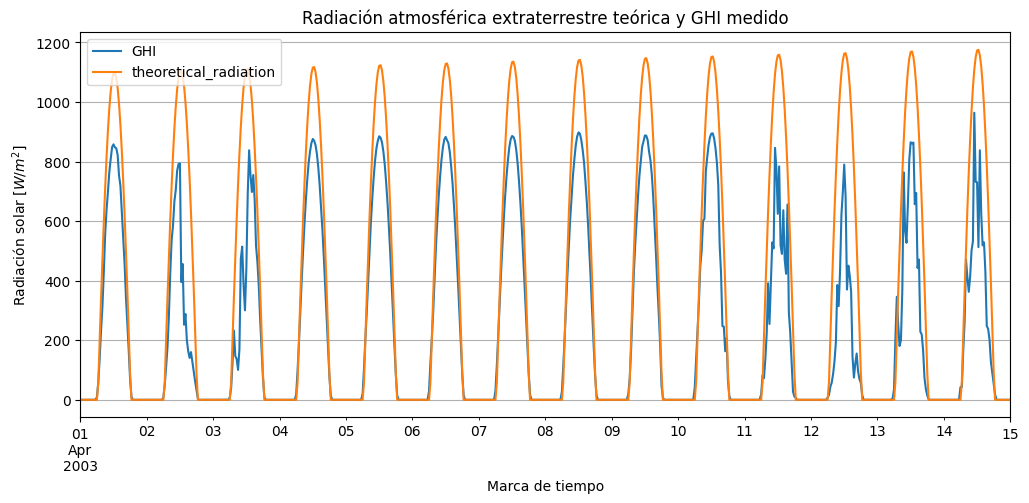

In [24]:
df_test[df_test.timestamp.between('2003-04-01', '2003-04-15')].plot(x = 'timestamp', y = ['GHI', 'theoretical_radiation'], figsize = (12, 5))
plt.title("Radiación atmosférica extraterrestre teórica y GHI medido")
plt.xlabel("Marca de tiempo")
plt.ylabel("Radiación solar $[W/m^{2}]$")
plt.grid()
plt.legend()
plt.show()

Este ejemplo, nos permite observar una concordancia en rangos de tiempo de disponibilidad de radiación solar medida y datos radiación solar extraterrestre estimada de manera teórico.

A continuación, el objetivo es realizar de manera iterativa el mismo procedimiento para todas las estaciones, adicionando la radiación solar teórica y guardando el dataset preparado `df_prep` por cada estación en un directorio `CyL_processed/` en formato `parquet`.

In [25]:
# Se mantiene la misma longitud del huso horario dado que todas las estaciones se encuentran en España
longitud_huso = 0

# Obtenemos el listado de estaciones a partir del dataframe de datos geográficos
station_codes = df_geo['station_code'].tolist()

# Creamos el directorio de salida con los datos preparados
os.makedirs("CyL_processed", exist_ok = True)

# Para cada código de estación se adiciona el valor estimado teórico de radiación solar extraterreste.
for station in station_codes:
    # Lectura de los datos por estación
    df_prep = pd.read_csv(f"temp_CyL_stations/{station}.csv", sep = ',', header=0)
    # Ajuste tipo dato marca de tiempo
    df_prep['timestamp'] = pd.to_datetime(df_prep.timestamp, format = '%Y-%m-%d %H:%M:%S')
    # Obtenemos latitud y longitud para la estación
    latitude = df_geo[df_geo.station_code == station]['latitude'].iloc[0]
    longitude = df_geo[df_geo.station_code == station]['longitude'].iloc[0]
    # Calculo de radiación teórica
    df_prep['theoretical_radiation'] = df_prep.apply(lambda row : radiacion_solar_teorica(row['timestamp'].dayofyear,
                     row["timestamp"].hour + row["timestamp"].minute/60., latitude, longitude, longitud_huso), axis = 1)
    # Guardado del dataset preparado en formato parquet para mantener el schema de datos
    df_prep.to_parquet(f"CyL_processed/{station}.parquet", compression = 'snappy')

In [27]:
# Se genera un archivo comprimido en formato zip con todos los archivos procesados
! zip -q -r CyL_processed.zip CyL_processed # Se obtiene un archivo CyL_processed.zip

## Análisis descriptivo de los datos

In [18]:
# Ejemplo año 2002 estación AV01 Nava de Arévalo
latitud = df_geo[df_geo.station_code == 'AV01']['latitude'].iloc[0]
longitud = df_geo[df_geo.station_code == 'AV01']['longitude'].iloc[0]

# Se genera una matriz de ceros 366 (año bisiesto) días por 24 horas
radiacion_theo = np.zeros((366, 24))

# Se actualizan los valores de la matriz de acuerdo la radiación solar teórica
for i, dia in enumerate(np.arange(0, 366)):
    for j, hora in enumerate(np.arange(0, 24)):
        s = radiacion_solar_teorica(dia, hora, latitud, longitud, longitud_huso)
        if s < 0:
            s = 0
        radiacion_theo[i][j] = s

In [19]:
df_grouped = df_test.groupby([df_test['timestamp'].dt.date, df_test['timestamp'].dt.hour])[['GHI']].mean().copy()
df_grouped.index.names = ['DateLocal', 'HourLocal']
df_grouped.reset_index(inplace = True)
df_grouped['DayOfYear'] = pd.to_datetime(df_grouped['DateLocal'], format='%Y-%m-%d').dt.strftime('%j').astype(int)

radiacion = np.zeros((366, 24)) # 366 días dado que es un año bisiesto
for _, row in df_grouped.iterrows():
    radiacion[row['DayOfYear']-1][row['HourLocal']] = row['GHI']

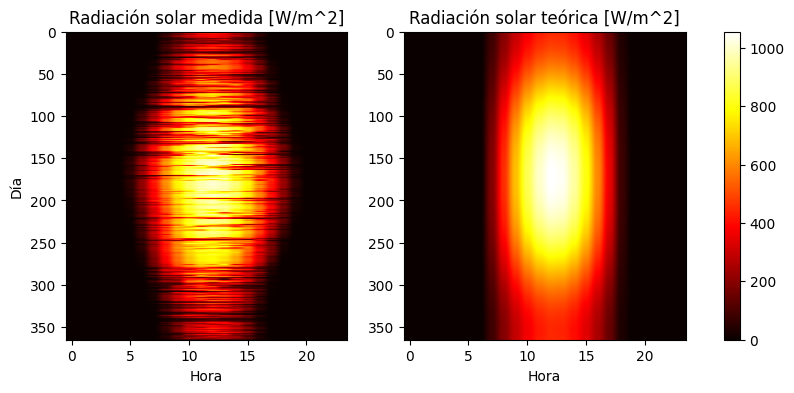

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de radiación solar medida
im = axs[0].imshow(radiacion, aspect='auto', cmap='hot')
axs[0].set_xlabel('Hora')
axs[0].set_ylabel('Día')
axs[0].set_title('Radiación solar medida [W/m^2]')
axs[0].grid(False)

# Gráfico de radiación solar teórica
im2 = axs[1].imshow(radiacion_theo, aspect='auto', cmap='hot')
axs[1].set_xlabel('Hora')
axs[1].set_title('Radiación solar teórica [W/m^2]')
axs[1].grid(False)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [29]:
df_test.describe()

,GHI,air_temp,humidity,precipitation,wind_sp,wind_dir,theoretical_radiation
count,52603.000000,52603.000000,52498.000000,52603.000000,52603.000000,52603.000000,52603.000000
mean,191.662101,11.444678,69.393970,0.023090,2.585075,206.715517,316.997457
std,280.611273,8.501992,23.674762,0.201364,1.882048,92.790300,408.266442
min,0.000000,-9.770000,7.920000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.360000,52.620000,0.000000,1.180000,162.750000,0.000000
50%,6.770000,10.010000,76.100000,0.000000,2.050000,217.200000,0.000000
75%,323.100000,16.620000,89.100000,0.000000,3.570000,278.300000,595.430417
max,1147.000000,38.240000,100.000000,13.400000,13.370000,360.000000,1347.521090


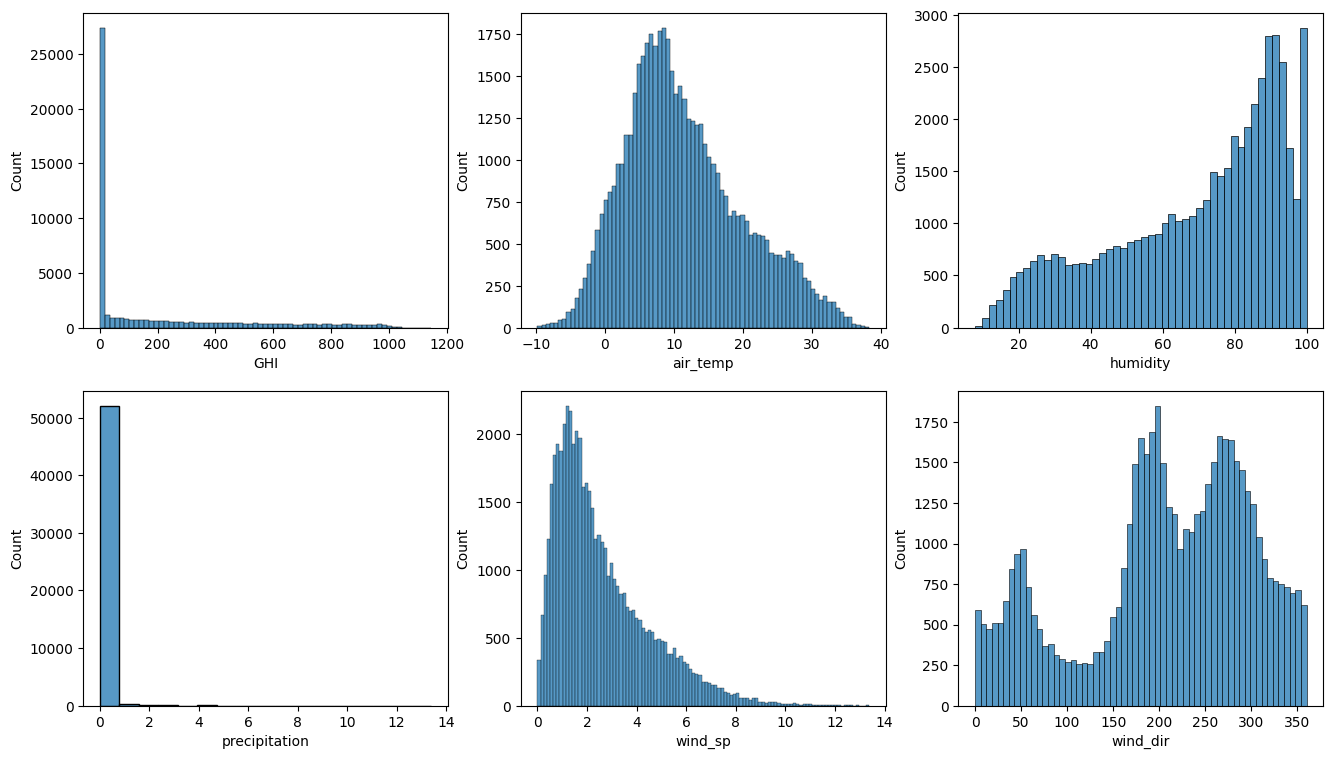

In [30]:
numVars = ['GHI','air_temp','humidity','precipitation','wind_sp','wind_dir']

# Distribución de las variables numéricas
fig, axes = plt.subplots(2, 3, figsize=(16,9))
for index, var in enumerate(numVars):
    sns.histplot(x = df_test[var] , ax=axes[index//3, index%3])

En cuanto a la distribución de los datos por variable se observa que:
* Tal como es de esperarse en cuanto a la radiación solar (GHI), la mayor parte de los datos son valores cercanos a 0 que corresponden a los espacios de tiempo
de horario nocturno.
* En cuanto a la temperatura del aire, se observa que los valores varían en su mayoría en un rango entre 5.3 y 16.6°C teniendo momentos en los que alcanza temperaturas superiores a 30°C con un máximo de 38°C medido.
* Se observa cierta tendencia a una humedad relativa alta con una mayor cantidad de mediciones cercanas al 100%
* La dirección del viento presenta muchas variaciones de su ángulo de incidencia con una mayor tendencia a aproximarse con ángulos entre 200 y 300 grados.
* La velocidad media aproximada del viento es cercana 2.5 m/s.

### Comportamiento de variables a través del tiempo

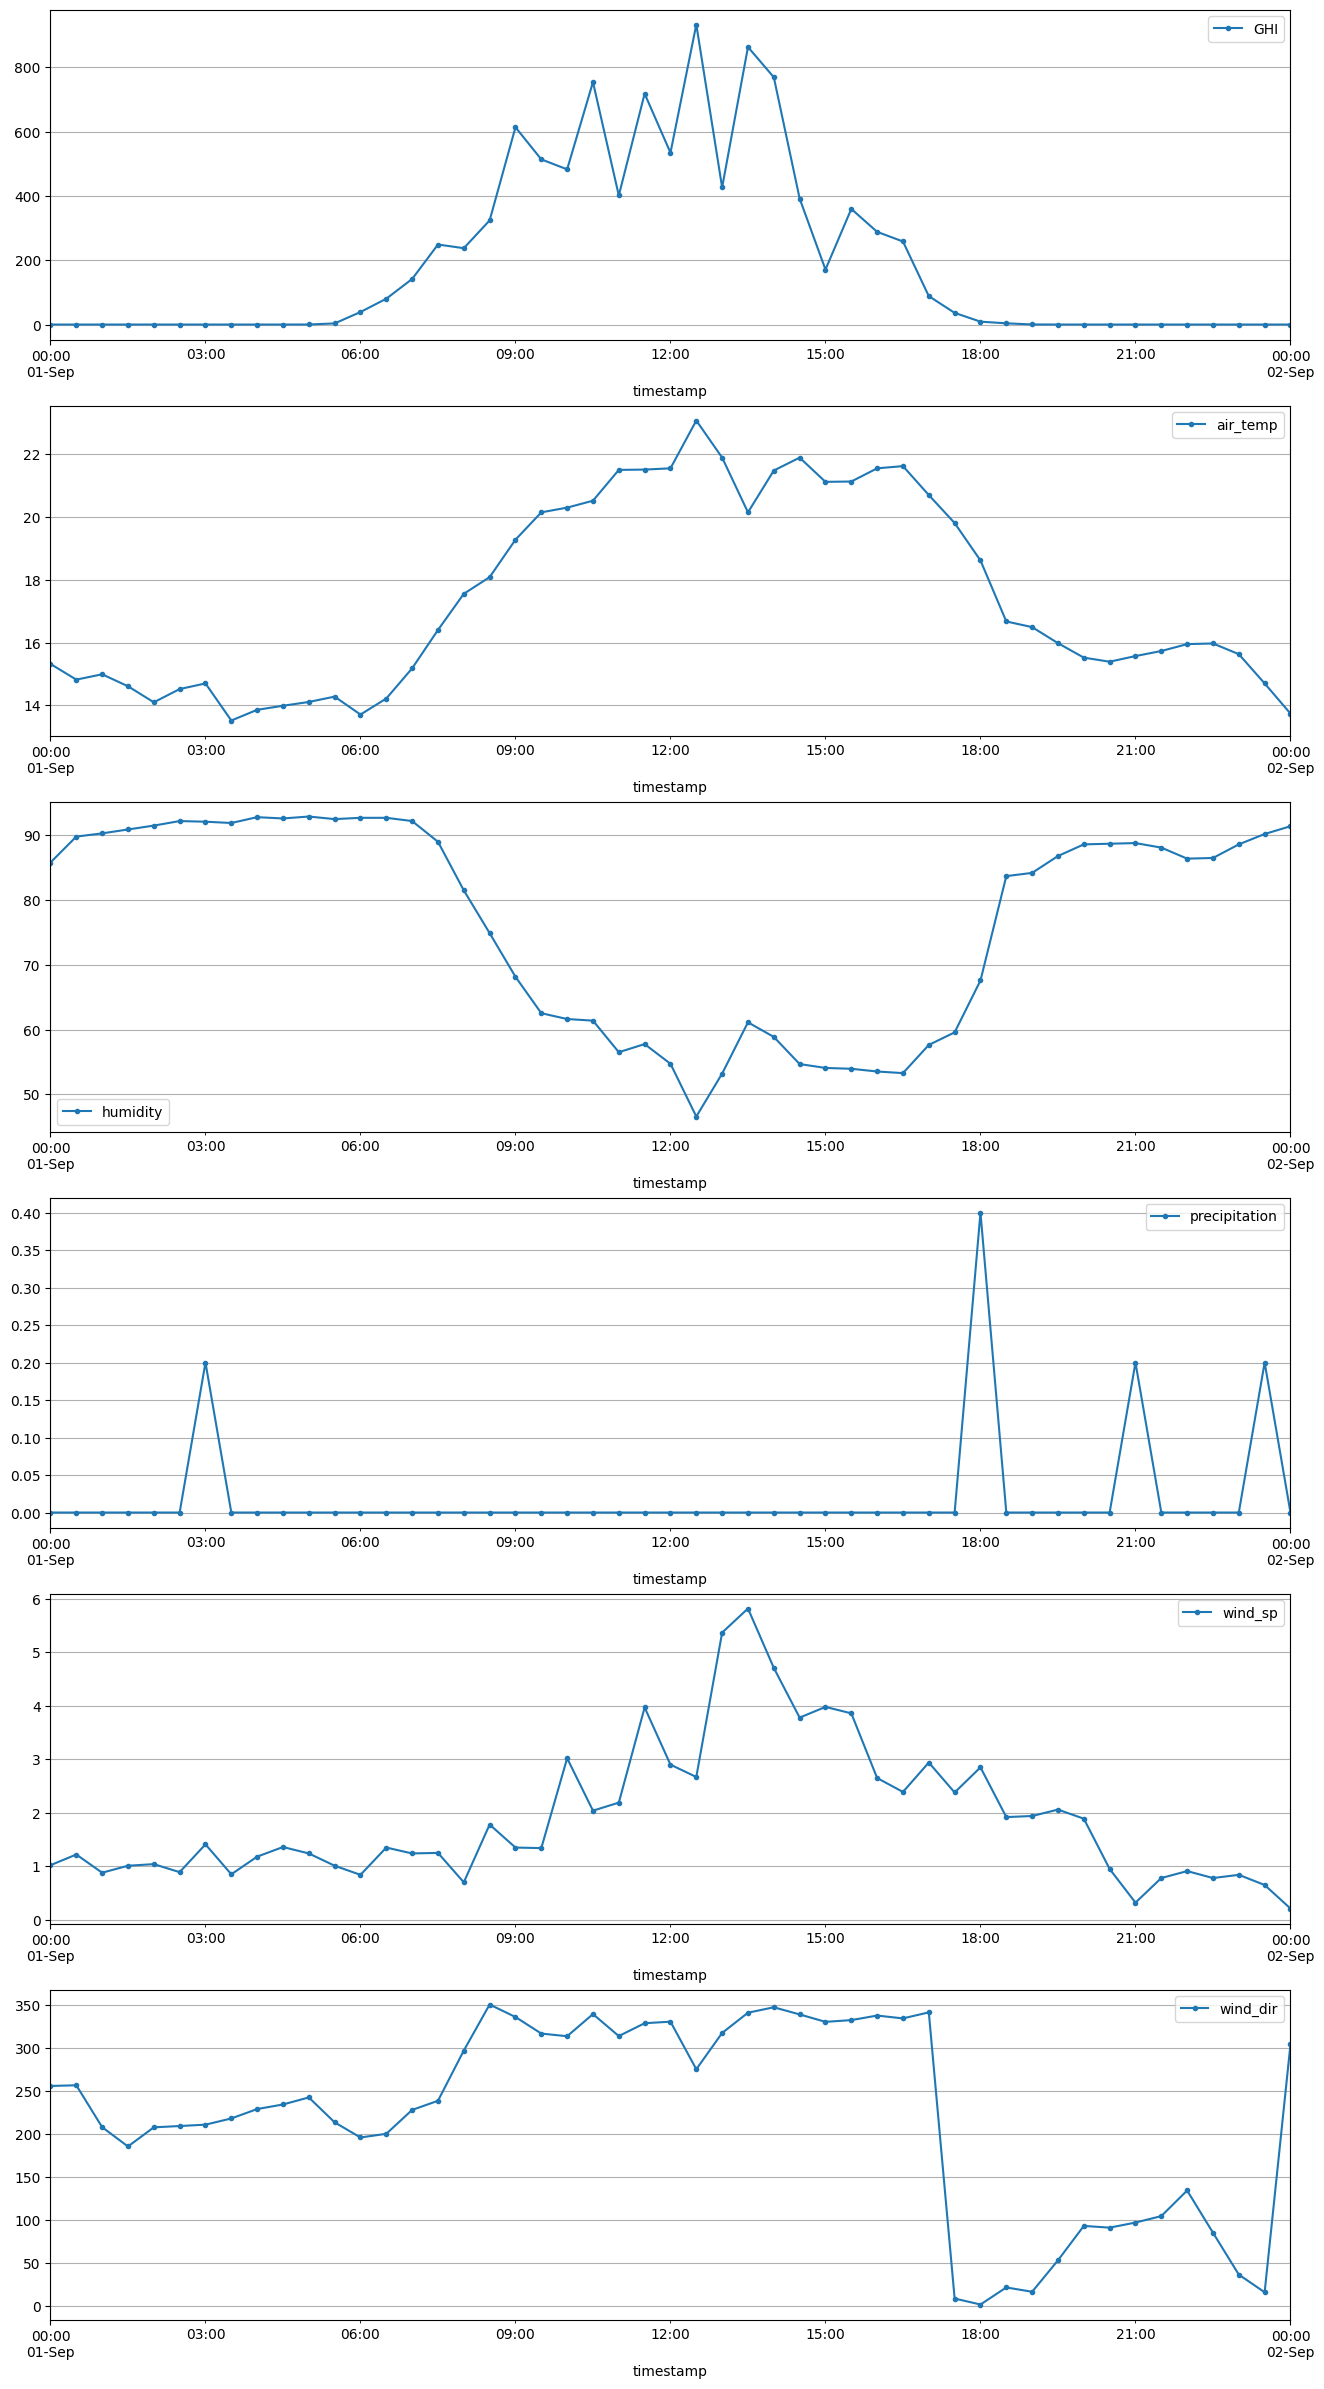

In [41]:
# Comportamiento de variables a través del tiempo para un espacio de 1 día entre 2003-09-01 y 2003-09-02
# para la estación AV01
fig, axes = plt.subplots(len(numVars), 1, figsize=(16,30))
for index, var in enumerate(numVars):
    df_test[df_test.timestamp.between('2003-09-01', '2003-09-02 ')].plot(x = 'timestamp', y = var, style='.-', ax=axes[index], grid=True)